In [1]:
using SDDP, Distributions, Gurobi, Plots

In [20]:
graph = SDDP.Graph(
           :root_node,
           [:decision_node,:demand_node],
           [
               (:root_node => :decision_node, 1.0),
               (:decision_node => :demand_node, 1.0)
           ]);

println("Defino Modelo...")

p = 1.0 #day ahead price
q = 2.0 #same day price

model = SDDP.PolicyGraph(
            graph,
            sense = :Min,
            lower_bound = 0,
            optimizer = with_optimizer(Gurobi.Optimizer,OutputFlag=false)) do subproblem, node

                @variable(subproblem, stock>=0, SDDP.State, initial_value = 0)

                @variable(subproblem, 0 <= reserve)
                @variable(subproblem, 0 <= shortage)

                @variable(subproblem, demand)

                @constraint(subproblem, stock.out == stock.in + reserve + shortage - demand)

                if node == :decision_node
                        JuMP.fix(demand,0.0)
                        JuMP.fix(shortage,0.0;force=true)
                else
                    demand_range = collect(0:100);
#                    demand_probability = pdf.(Poisson(20),demand_range);
                    demand_probability = ones(size(demand_range));
                    demand_probability ./= sum(demand_probability);

                    SDDP.parameterize(subproblem,demand_range,demand_probability) do d
                        JuMP.fix(demand,d)
                        JuMP.fix(reserve,0.0;force=true)
                    end
                end


                if node == :decision_node
                    @stageobjective(subproblem,  p*reserve);
                else
                    @stageobjective(subproblem,  q*shortage);
                end
            end;

Defino Modelo...

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only


In [22]:
SDDP.train(model,iteration_limit=20)
#AVAR version
#SDDP.train(model,risk_measure = SDDP.AVaR(1.0),iteration_limit=20)

--------------------------------------------------------------------------------
                      SDDP.jl (c) Oscar Dowson, 2017-20

Numerical stability report
  Non-zero Matrix range     [5e-01, 2e+00]
  Non-zero Objective range  [1e+00, 2e+00]
  Non-zero Bounds range     [0e+00, 0e+00]
  Non-zero RHS range        [4e+01, 1e+02]
No problems detected

Solver: serial mode

 Iteration    Simulation       Bound         Time (s)    Proc. ID   # Solves
        1    8.800000e+01   7.524752e+01   1.543808e-02          1       2184
        2    7.400000e+01   7.524752e+01   3.438091e-02          1       2288
        3    1.140000e+02   7.524752e+01   4.690599e-02          1       2392
        4    1.460000e+02   7.524752e+01   6.350803e-02          1       2496
        5    5.000000e+01   7.524752e+01   7.473803e-02          1       2600
        6    1.140000e+02   7.524752e+01   8.701706e-02          1       2704
        7    7.800000e+01   7.524752e+01   1.030641e-01          1       28

In [11]:
results=SDDP.simulate(model,100,[:reserve,:stock,:demand,:shortage]);

┌ Warning: Attribute alias `alpha` detected in the user recipe defined for the signature (::SDDP.PublicationPlot). To ensure expected behavior it is recommended to use the default attribute `seriesalpha`.
└ @ Plots /home/andres/.julia/packages/Plots/6RLiv/src/pipeline.jl:15
┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SDDP.PublicationPlot). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots /home/andres/.julia/packages/Plots/6RLiv/src/pipeline.jl:15
┌ Warning: Attribute alias `alpha` detected in the user recipe defined for the signature (::SDDP.PublicationPlot). To ensure expected behavior it is recommended to use the default attribute `seriesalpha`.
└ @ Plots /home/andres/.julia/packages/Plots/6RLiv/src/pipeline.jl:15
┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SDDP.PublicationPlot). To ensure expected behavior it is recommended to use the default att

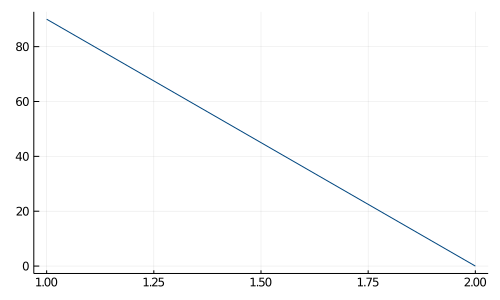

In [12]:
p1 = plot(
    SDDP.publication_plot(results, title="Purchase") do data
        return data[:reserve]
    end
    )

┌ Warning: Attribute alias `alpha` detected in the user recipe defined for the signature (::SDDP.PublicationPlot). To ensure expected behavior it is recommended to use the default attribute `seriesalpha`.
└ @ Plots /home/andres/.julia/packages/Plots/6RLiv/src/pipeline.jl:15
┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SDDP.PublicationPlot). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots /home/andres/.julia/packages/Plots/6RLiv/src/pipeline.jl:15
┌ Warning: Attribute alias `alpha` detected in the user recipe defined for the signature (::SDDP.PublicationPlot). To ensure expected behavior it is recommended to use the default attribute `seriesalpha`.
└ @ Plots /home/andres/.julia/packages/Plots/6RLiv/src/pipeline.jl:15
┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SDDP.PublicationPlot). To ensure expected behavior it is recommended to use the default att

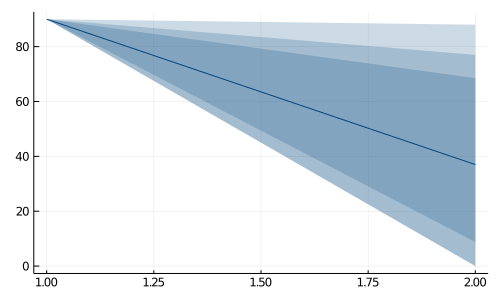

In [13]:
p2 = plot(

    SDDP.publication_plot(results, title="Stock") do data
        return data[:stock].out
    end
    )

┌ Warning: Attribute alias `alpha` detected in the user recipe defined for the signature (::SDDP.PublicationPlot). To ensure expected behavior it is recommended to use the default attribute `seriesalpha`.
└ @ Plots /home/andres/.julia/packages/Plots/6RLiv/src/pipeline.jl:15
┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SDDP.PublicationPlot). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots /home/andres/.julia/packages/Plots/6RLiv/src/pipeline.jl:15
┌ Warning: Attribute alias `alpha` detected in the user recipe defined for the signature (::SDDP.PublicationPlot). To ensure expected behavior it is recommended to use the default attribute `seriesalpha`.
└ @ Plots /home/andres/.julia/packages/Plots/6RLiv/src/pipeline.jl:15
┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SDDP.PublicationPlot). To ensure expected behavior it is recommended to use the default att

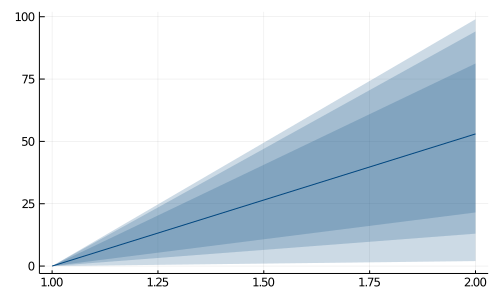

In [14]:
p3 = plot(
    SDDP.publication_plot(results, title="Demand") do data
        return data[:demand]
    end
    )

┌ Warning: Attribute alias `alpha` detected in the user recipe defined for the signature (::SDDP.PublicationPlot). To ensure expected behavior it is recommended to use the default attribute `seriesalpha`.
└ @ Plots /home/andres/.julia/packages/Plots/6RLiv/src/pipeline.jl:15
┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SDDP.PublicationPlot). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots /home/andres/.julia/packages/Plots/6RLiv/src/pipeline.jl:15
┌ Warning: Attribute alias `alpha` detected in the user recipe defined for the signature (::SDDP.PublicationPlot). To ensure expected behavior it is recommended to use the default attribute `seriesalpha`.
└ @ Plots /home/andres/.julia/packages/Plots/6RLiv/src/pipeline.jl:15
┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SDDP.PublicationPlot). To ensure expected behavior it is recommended to use the default att

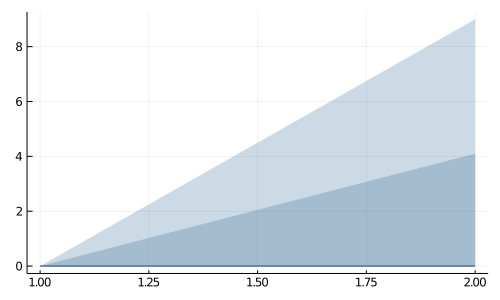

In [15]:
p4 = plot(
        SDDP.publication_plot(results, title="Shortage") do data
            return data[:shortage]
        end
        )